# Project Overview

## Package Imports

In [1]:
# basic tools
import pandas as pd
import numpy as np
import time
from collections import Counter

# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split

# scoring and algorithm selection packages
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, HalvingGridSearchCV, learning_curve, StratifiedKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score

# resampling packages
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, NearMiss, RandomUnderSampler, OneSidedSelection, NeighbourhoodCleaningRule

# model packages
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier
import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import umap.plot
#import geopandas as gpd
#from shapely.geometry import Point,Polygon
#from descartes import PolygonPatch
#from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# ignore warnings (gets rid of Pandas copy warnings)
import warnings
warnings.filterwarnings('ignore')

In [2]:
from ipynb.fs.full.functions import pipeline_fit_preprocessor, pipeline_transform_preprocessor, spot_check_classifier, make_classifier, grid_optimizer

## Notebook Functions

In [2]:
def pipeline_fit_preprocessor(x):
    
    ''' Takes in a dataframe and adds polynomial features and scaling
    arguments: dataframe
    returns: transformed dataframe and fit pipe object'''
    
    
    # Create a column transformer to add polynomial features to Segment Number
    print("Setting up transforms - Polynomials, StandardScaler")
    poly_transforms = ColumnTransformer(transformers=[
        ("polys", PolynomialFeatures(degree=3, include_bias=False), poly_features),
        ], remainder="passthrough") 
    
    

    print('Setting up processing pipeline')
    pipe = Pipeline([
                ('transforms1', poly_transforms),
                ('scl', StandardScaler()),
            ])
    
    print('Fitting pipeline on train data')
    transformed_data = pipe.fit_transform(x)
    
    # Re-apply labels
    category_labels = list(x.columns)
    category_labels.remove('SEGMENT_NUMBER')
    category_labels.remove('DEP_BLOCK_HIST')
    all_cols = ['SEGMENT_NUMBER', "DEP_BLOCK_HIST", "SEGMENT_POLY", "JUNK",  "DEP_BLOCK_HIST_POLY", "SEGMENT_POLY2", 
               "JUNK2", "JUNK3", "DEP_BLOCK_HIST_POLY2"]+list(category_labels)
    
    df= pd.DataFrame(transformed_data,  columns=all_cols, index=x.index)
    df.drop(['JUNK', 'JUNK2', 'JUNK3'], axis=1, inplace=True)
    
    return df, pipe

def pipeline_transform_preprocessor(x, pipe):
    
    ''' Takes in a dataframe and fit pipe object,
    and adds polynomial features and scaling
    arguments: dataframe, pipe object
    returns: transformed dataframe'''
    
    print('Transforming test data')
    transformed_data = pipe.transform(x)
    
    # Re-apply labels
    category_labels = list(x.columns)
    category_labels.remove('SEGMENT_NUMBER')
    category_labels.remove('DEP_BLOCK_HIST')
    all_cols = ['SEGMENT_NUMBER', "DEP_BLOCK_HIST", "SEGMENT_POLY", "JUNK",  "DEP_BLOCK_HIST_POLY", "SEGMENT_POLY2", 
               "JUNK2", "JUNK3", "DEP_BLOCK_HIST_POLY2"]+list(category_labels)
    
    df= pd.DataFrame(transformed_data,  columns=all_cols, index=x.index)
    df.drop(['JUNK', 'JUNK2', 'JUNK3'], axis=1, inplace=True)
    
    return df


In [3]:
def spot_check_model(model, train, y_train, title, test, y_test):
    
    '''Takes in a model as well as train and test sets. Runs model using cv 3 and appends model scores to the list
    Arguments:
    model pre-defined with hyperparameters
    train and test x and y
    title string to define the model on the scores list'''
    
    # log start time of model run
    start=time.time()
    
    # Identify model being run
    print("\n\nRunning", title, "Classification")
    
    # fit model to train data
    model.fit(train, y_train)
    
    # get accuracy cross val score for cv 3
    scores = cross_validate(model, train, y_train, cv=3,
        scoring=('f1', 'accuracy', 'roc_auc'),
        return_train_score=True)
    f1 = round(scores['test_f1'].mean()*100,2)
    accs = round(scores['test_accuracy'].mean()*100, 2)
    auc = round(scores['test_roc_auc'].mean()*100, 2)
    
    print("CV 3 Accuracy Train Score: {}".format(accs))
    print("CV 3 F1 Train Score: {}".format(f1))
    print("CV 3 Auc Train Score: {}".format(auc))
    
    # make predictions on test data
    preds = model.predict(test)
    
    # Print Testing accuracy
    accs = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, preds)
    print('\nTesting Accuracy: ', accs)
    print('Testing f1 Score: ', f1)
    print('Testing AUC Score: ', auc, '\n')
    
    # print classification report
    print(classification_report(y_test, preds))
    
    # append our results to our lists
    spot_check['Model'].append(title)
    spot_check['f1'].append(f1)
    spot_check['accuracy'].append(accs)
    spot_check['auc'].append(auc)
    spot_check['time'].append(time.time() - start)
    
    print(f'Elapsed Time: {time.time() - start}') 

In [4]:
def make_model(model, train, test, y_train, y_test, title):
    
    '''Takes in a model as well as train and test sets. Runs model using cv 5 and appends model scores to the list.
    This model prints a confusion matrix and visual ROCUC. 
    Arguments:
    model pre-defined with hyperparameters
    train and test x and y
    title string to define the model on the scores list'''
    
    # log start time of model run
    start=time.time()
    
    # Identify model being run
    print("\n\nRunning", title, "Classification")
    
    # fit model to train data
    model.fit(train, y_train)
    
    # get accuracy cross val score for cv 10
    scores = cross_validate(model, train, y_train, cv=10,
        scoring=('f1', 'accuracy', 'roc_auc'),
        return_train_score=True)
    f1 = round(scores['test_f1'].mean()*100,2)
    accs = round(scores['test_accuracy'].mean()*100, 2)
    auc = round(scores['test_roc_auc'].mean()*100, 2)
    
    print("CV 10 Accuracy Train Score: {}".format(accs))
    print("CV 10 F1 Train Score: {}".format(f1))
    print("CV 10 Auc Train Score: {}".format(auc))
    
    # make predictions on test data
    preds = model.predict(test)
    
    # Print Testing accuracy
    accuracy = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, preds)
    print('\nTesting Accuracy: ', accuracy)
    print('Testing f1 Score: ', f1)
    print('Testing AUC Score: ', auc, '\n')
    
    # print classification report
    print(classification_report(y_test, preds))
    
    # Visualize Confusion Matrix
    print("\nConfusion Matrix for Test Set")
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_title('Confusion Matrx')
    plot_confusion_matrix(model, test, y_test, cmap=plt.cm.Blues, ax=ax)
    plt.show()
    
    # Get false positive, true positive, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, preds)

    # Visualize AUC
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    plt.figure(figsize=(15,10))
    plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # append our scores to our lists
    models['Model'].append(title)
    models['f1'].append(f1)
    models['accuracy'].append(accuracy)
    models['auc'].append(auc)
    models['time'].append(time.time() - start)
    
    print(f'Elapsed Time: {time.time() - start}')

In [5]:
def grid_optimizer(model, grid, x, y):
    
    '''Takes in a model and a grid of hyperparameters, and runs a HalvingGridSearch
    arguments: model, parameter grid, x and y to check parameter grid
    returns: best parameters'''
    
    start=time.time()
    
    print("Making Search")
    grid_search = HalvingGridSearchCV(model, grid, verbose=10, scoring='roc_auc', cv=3, n_jobs=-1, min_resources='exhaust')

    print("Running Grid")
    grid_search.fit(x, y)

    grid_search.best_estimator_
    
    # Best f1
    print('Best roc_auc: %.3f' % grid_search.best_score_)

    print("Best parameters set found on train set: \n")
    print(grid_search.best_params_)
    print("\nGrid scores on train set:\n")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    print(f'Elapsed Time: {time.time() - start}')
    
    return grid_search.best_params_

# Explore/Visualize Data

In [6]:
# Load ALL Data
final = pd.read_pickle("data/pkl/train_delays.pkl")
final

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,...,SNWD,TMAX,AWND,DELAY_REASON,index,DELAY_TYPE_FREQUENCY,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
0,4,7,2100-2159,3,1,33,50,American Eagle Airlines Inc.,7011,25138,...,0.0,86.0,7.16,CARRIER,CARRIER,0.289498,0.146509,0.204697,0.203729,0.264607
1,3,4,2200-2259,1,5,11,100,JetBlue Airways,11110,25502,...,0.0,57.0,11.18,MIXED,MIXED,0.143070,0.249290,0.165380,0.179152,0.194965
2,5,4,1800-1859,2,5,15,143,Southwest Airlines Co.,5562,113709,...,0.0,84.0,8.05,LATE_AIRCRAFT,LATE_AIRCRAFT,0.420148,0.248016,0.239330,0.250504,0.309200
3,3,1,1700-1759,3,5,28,142,United Air Lines Inc.,11006,53007,...,0.0,60.0,9.17,NAS,NAS,0.112334,0.184016,0.180546,0.161062,0.224798
4,8,1,1800-1859,6,8,10,143,Southwest Airlines Co.,4742,114987,...,0.0,78.0,6.04,LATE_AIRCRAFT,LATE_AIRCRAFT,0.420148,0.192933,0.242930,0.181530,0.309009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710859,4,1,2000-2059,1,8,23,100,JetBlue Airways,12669,24966,...,0.0,54.0,11.63,LATE_AIRCRAFT,LATE_AIRCRAFT,0.420148,0.266494,0.149187,0.238144,0.247386
710860,5,6,1100-1159,5,3,20,181,American Airlines Inc.,8145,78894,...,0.0,88.0,10.96,LATE_AIRCRAFT,LATE_AIRCRAFT,0.420148,0.256803,0.286236,0.179506,0.163243
710861,2,4,1200-1259,6,2,50,76,Mesa Airlines Inc.,13272,15953,...,0.0,84.0,7.16,CARRIER,CARRIER,0.289498,0.208413,0.145307,0.244909,0.228026
710862,8,4,1800-1859,1,7,3,50,Comair Inc.,1181,24496,...,0.0,89.0,4.92,LATE_AIRCRAFT,LATE_AIRCRAFT,0.420148,0.232407,0.209670,0.241347,0.309009


In [10]:
y = final['DELAY_REASON'].value_counts()
y

LATE_AIRCRAFT    298668
CARRIER          205794
MIXED            101703
NAS               79854
WEATHER           23541
SECURITY           1304
Name: DELAY_REASON, dtype: int64

''

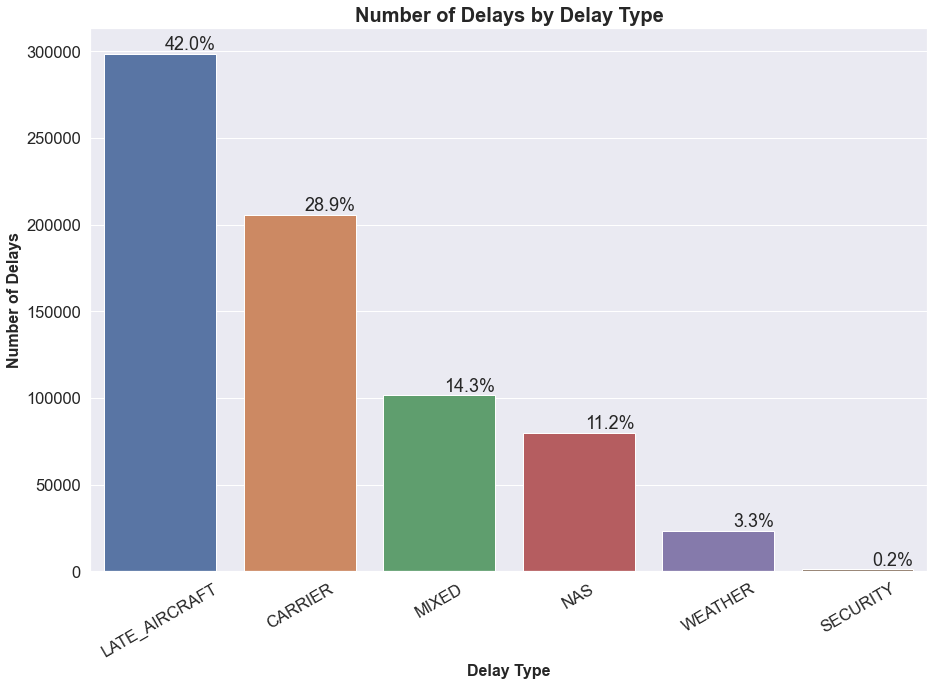

In [11]:
sns.set(font_scale = 1.5) # reset our scale

# create our figure
fig, ax=plt.subplots(figsize=(15,10))


# set up our barplot
bar4 = sns.barplot(x=y.index, y=y, data=final)


total = float(sum(y))

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha="right",va="bottom")


# label our visualization

bar4.set_xticklabels(bar4.get_xticklabels(),rotation=30)
bar4.set_ylabel('Number of Delays',weight='bold',fontsize=16)
bar4.set_xlabel('Delay Type', weight='bold',fontsize=16)
bar4.set_title('Number of Delays by Delay Type',weight='bold',fontsize=20)

# save figure to png
#plt.savefig('images/delay_type.png')
;
